In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
filepath = '../../../Project/data/'

In [333]:
recidivism_df = pd.read_csv(filepath + 'recidivism_dataset.csv')

In [334]:
recidivism_df.head()

,Unnamed: 0,ID_VARIABLE,NEW_DOS,NEW_DOF,PRS,NEW_INC_SANCTION_EXISTS,ADJ_JPMIN,AT_RISK_DT,COUNTY,NEXT_DOF,TIME_TO_RECIDIVATE,RECIDIVISM_3Y,RECIDIVISM_5Y,OGS,DOB,OFF_RACE,OFF_SEX
0,0,1000001,2010-02-18,2009-06-25,0,Y,16.0,2010-03-06,Schuylkill,NaN,NaN,0,0,3.0,1990-05-28,White,M
1,1,1000002,2017-01-31,2015-09-01,4,Y,120.0,2017-05-31,Somerset,NaN,NaN,0,0,3.0,1958-07-12,White,F
2,2,1000003,2002-05-08,2001-09-07,0,N,0.0,2002-05-08,Northampton,2009-03-04,2492.0,0,0,3.0,1961-08-14,White,F
3,3,1000003,2009-03-04,2009-03-04,3,Y,92.0,2009-06-04,Northampton,NaN,NaN,0,0,3.0,1961-08-14,White,F
4,4,1000004,2013-12-10,2013-09-19,0,N,0.0,2013-12-10,Franklin,2018-07-09,1672.0,0,1,1.0,1993-09-21,Unknown,M


In [335]:
recidivism_df['NEW_DOF'] = pd.to_datetime(recidivism_df['NEW_DOF'])
recidivism_df['NEW_DOS'] = pd.to_datetime(recidivism_df['NEW_DOS'])

In [336]:
recidivism_df['NEXT_DOF'] = pd.to_datetime(recidivism_df['NEXT_DOF'])

### Time to Conviction Analysis

In [337]:
time_to_conviction = recidivism_df['NEW_DOS'] - recidivism_df['NEW_DOF']

In [338]:
time_to_conviction.describe()

count                        1119074
mean     363 days 01:02:00.281589960
std      378 days 20:29:54.351646904
min                  0 days 00:00:00
25%                165 days 00:00:00
50%                257 days 00:00:00
75%                421 days 00:00:00
max               7993 days 00:00:00
dtype: object

In [619]:
sns.set_style(style='white') 
#palette = ['#9398f2', '#F29398',  '#ffcf6f']
palette = ['#7B86BD', '#FFE347', '#F07B46', '#67E6AC', '#15B5FF' ]
race_palette = ['#7B86BD', '#FFE347', '#D3D3D3']
sns.set_palette(palette)

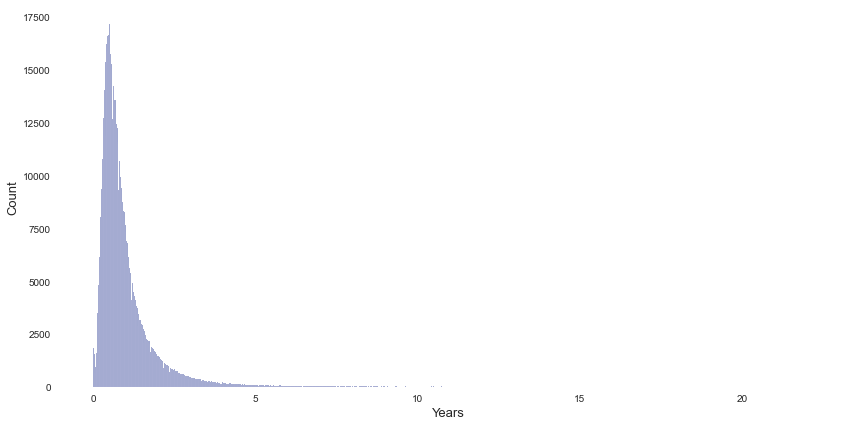

In [340]:
fig, ax = plt.subplots(figsize=(14, 7))

p = sns.histplot(time_to_conviction.dt.days/365,  ax=ax)
sns.despine(top=True, right=True, left=True, bottom=True)
#p.set_title('# of Years Between DOF and DOS', fontsize=16)
p.set_ylabel('Count', fontsize=13)
p.set_xlabel('Years', fontsize=13)
plt.show()

### Cohort Analysis

In [341]:
(time_to_conviction.dt.days<=4*365).sum()/len(time_to_conviction)

0.9803811008029854

In [342]:
recidivism_df['YOS'] = recidivism_df['NEW_DOS'].dt.year

In [343]:
def create_sentencing_cohorts(x):
    if x <= 2005:
        cohort = '2001-2005'
    elif x <= 2012:
        cohort = '2006-2012'
    elif x <= 2015: 
        cohort = '2013-2015'
    else: 
        return np.nan
    return cohort

In [344]:
recidivism_df['SENTENCING_COHORT'] = recidivism_df['YOS'].apply(lambda x: create_sentencing_cohorts(x))

In [345]:
recidivism_df['PRS'] = recidivism_df['PRS'].str.upper()

In [346]:
# recidivism_counts = recidivism_df[['SENTENCING_COHORT', 'PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS', 'SENTENCING_COHORT']).agg({'RECIDIVISM_3Y':'sum'})
# total_counts = recidivism_df[['SENTENCING_COHORT', 'PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS', 'SENTENCING_COHORT']).agg({'RECIDIVISM_3Y':'count'})
# recidivism_pct = recidivism_counts.div(total_counts).reset_index()

In [700]:
def get_grouping(df, category, labs = None, pct_of_category = False):

    recidivism_counts = df[[category, 'PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS', category]).agg({'RECIDIVISM_3Y':'sum'})
    if pct_of_category: # flip to True if we want to output recidivism rate by category grouping
        total_counts = df[[category, 'PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS', category]).agg({'RECIDIVISM_3Y':'count'}) 
    else:
        total_counts = df[['PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS']).agg({'RECIDIVISM_3Y':'count'})
    recidivism_pct = recidivism_counts.div(total_counts).apply(lambda x: x * 100).reset_index()  
    #cat_pct = df.groupby(by=category)['RECIDIVISM_3Y'].sum()/len(recidivism_df[recidivism_df['RECIDIVISM_3Y']==1]) 
    cat_pct = df.groupby(by=category)['RECIDIVISM_3Y'].sum()/df.groupby(by=category)['RECIDIVISM_3Y'].count()
    
    # for i in range(len(labs)):
    #     labs[i] = labs[i] + ' {:.1f}%'.format(cat_pct.iloc[i] * 100)
    if labs is not None:
        recidivism_pct[category].replace(to_replace = list(range(len(labs))), value = labs, inplace=True)
    return recidivism_counts, total_counts, recidivism_pct, cat_pct, labs

In [627]:
recidivism_counts, total_counts, recidivism_pct, cat_pct, labs = get_grouping(recidivism_df, 'SENTENCING_COHORT', pct_of_category = True)

In [347]:
# recidivism_df.groupby(by='SENTENCING_COHORT')['RECIDIVISM_3Y'].count()/len(recidivism_df)

SENTENCING_COHORT
2001-2005    0.230975
2006-2012    0.401059
2013-2015    0.218098
Name: RECIDIVISM_3Y, dtype: float64

In [633]:
cat_pct = pd.DataFrame(cat_pct)

In [635]:
cat_pct.reset_index(inplace=True)

In [660]:
cat_pct['RECIDIVISM_3Y'] = cat_pct['RECIDIVISM_3Y'] * 100

In [675]:
recidivism_by_yos = recidivism_df.groupby(by='YOS')['RECIDIVISM_3Y'].sum().div(recidivism_df.groupby(by='YOS')['RECIDIVISM_3Y'].count()) * 100

In [676]:
recidivism_by_yos.loc[:2015]

YOS
2001    15.295347
2002    14.123800
2003    13.165977
2004    14.351282
2005    15.084485
2006    16.858843
2007    17.868908
2008    18.246992
2009    18.769643
2010    18.611442
2011    19.314102
2012    19.989094
2013    19.612998
2014    19.602652
2015    18.684490
Name: RECIDIVISM_3Y, dtype: float64

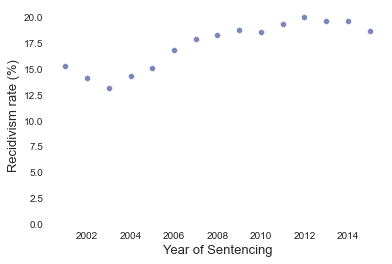

In [679]:
fig, ax = plt.subplots()
p = sns.scatterplot(data = recidivism_by_yos.loc[:2015])
sns.despine(top=True, right=True, left=True, bottom=True)
p.set_xlabel('Year of Sentencing', fontsize=13)
p.set_ylabel('Recidivism rate (%)', fontsize=13)
ax.set_ylim(0, 21)
plt.show()

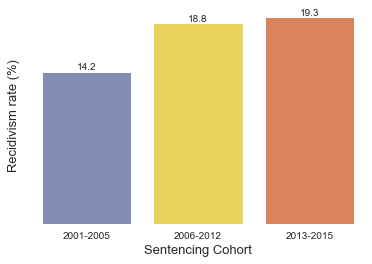

In [662]:
fig, ax = plt.subplots()
p = sns.barplot(data = cat_pct, x = 'SENTENCING_COHORT', y = 'RECIDIVISM_3Y')
sns.despine(top=True, right=True, left=True, bottom=True)
p.set_xlabel('Sentencing Cohort', fontsize=13)
p.set_ylabel('Recidivism rate (%)', fontsize=13)
p.set(yticklabels=[])
n_cats = 1
for i in range(n_cats):
    ax.bar_label(ax.containers[i], label_type='edge', fmt='%1.1f')
plt.show()

In [642]:
def plot_category(category, df, legend_loc = 'upper left', 
                x = 'PRS', y = 'RECIDIVISM_3Y', palette = palette, 
                legend_title = None, hue_order = None, figsize = (14, 8)):
                
    fig, ax = plt.subplots(figsize=figsize) 
    sns.set_palette(palette)
    p = sns.barplot(x=x, y=y, hue=category, data=df,  ax=ax, hue_order = hue_order)
    sns.despine(top=True, right=True, left=True, bottom=True)
    p.set_xlabel('PRS score category', fontsize=13)
    p.set_ylabel('Recidivism rate (%)', fontsize=13)
    p.set(yticklabels=[])
    ax.legend(loc= legend_loc, title = legend_title) 
    n_cats = len(df[category].unique())
    for i in range(n_cats):
        ax.bar_label(ax.containers[i], label_type='edge', fmt='%1.1f')

    plt.show()

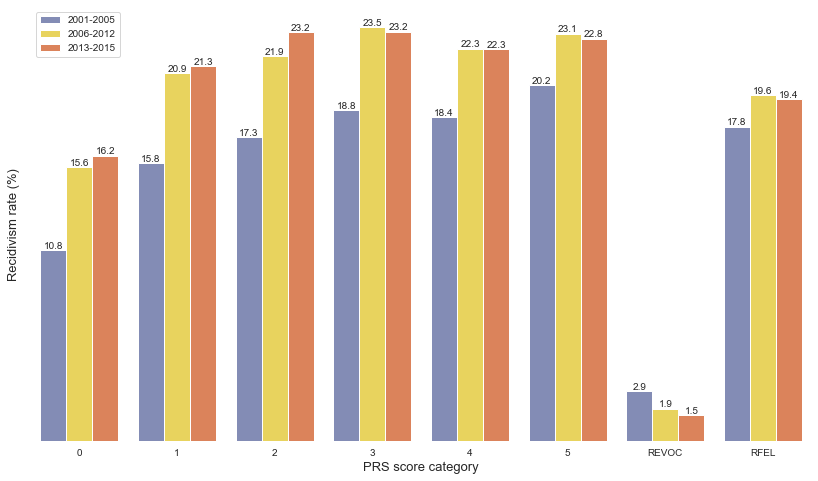

In [628]:
plot_category('SENTENCING_COHORT', recidivism_pct)

In [349]:
# recidivism_df.drop(columns='Unnamed: 0', inplace=True)

In [350]:
# recidivism_df.to_csv(filepath + 'recidivism_dataset_v1.csv', index=False)

### Offense category/severity analysis

In [257]:
offense_df = pd.read_csv(filepath + 'PSC_data_trimmed_v1.csv')

C:\Users\audre\AppData\Local\Temp\ipykernel_36240\2586665104.py:1: DtypeWarning: Columns (19,29,45,46,48,49,50,51,52,53,59,63,64,66) have mixed types. Specify dtype option on import or set low_memory=False.
  offense_df = pd.read_csv(filepath + 'PSC_data_trimmed_v1.csv')


In [258]:
ofn_label_vars = ['JPR_ID', 'ID_VARIABLE', 'DOS', 'DOF', 'OFN_LABEL', 'LABEL', 'OGS']
offense_df = offense_df[ofn_label_vars].copy()

In [259]:
offense_df['DOS'] = pd.to_datetime(offense_df['DOS'])

In [260]:
offense_df['_DOS'] = offense_df['DOS']
offense_df['DOS'] = offense_df.groupby(by=['ID_VARIABLE', 'JPR_ID'])['DOS'].transform('min')

In [261]:
offense_df['DOF'] = pd.to_datetime(offense_df['DOF'])

In [262]:
offense_df['_DOF'] = offense_df['DOF']
offense_df['DOF'] = offense_df.groupby(by=['ID_VARIABLE', 'JPR_ID'])['DOF'].transform('min')

In [263]:
# There are 79 charges with missing LABEL information. replace with OFN_LABEL column
offense_df['LABEL'].fillna(offense_df['OFN_LABEL'], inplace=True)

##### Recidivism to DUI 

In [717]:
#recidivism_df.drop(columns=['DOF_x', 'DOF_y', 'NEXT_OFN_DUI'], inplace=True)

In [750]:
dui_codes = list(offense_df[offense_df['LABEL'].str.contains('DUI')]['LABEL'].unique())

In [751]:
dui_codes += list(offense_df[offense_df['LABEL'].str.contains('BUI')]['LABEL'].unique())

In [752]:
dui_codes

['DUI 97-M2',
 'DUI 97-M1',
 'Homicide-By Veh (No DUI)',
 'Assault-Agg By Veh while DUI',
 'Homicide-By Veh while DUI',
 'Homicide-By Veh (DUI)',
 'DUI-M2',
 'DUI-M1',
 'DUI-M',
 'DUI-M1 Minor Occupant',
 'DUI-F3',
 'DUI-high rate of alcohol: BAC .10-<.16 (4th/subsq off)',
 'DUI-general impairment: BAC .08-<.10 (4th/subsq off)',
 'Homicide by vehicle while DUI - prior DUI conviction(s)',
 'DUI-controlled substances: metabolite of Sched I/II/III (3rd/subsq off)',
 'DUI-general impairment: BAC .08-<.10 (3rd off)',
 'BUI:',
 'BUI']

In [753]:
dui_codes = [i for i in dui_codes if 'Homicide' not in i and 'No DUI' not in i and 'Assault' not in i]

In [754]:
dui_codes

['DUI 97-M2',
 'DUI 97-M1',
 'DUI-M2',
 'DUI-M1',
 'DUI-M',
 'DUI-M1 Minor Occupant',
 'DUI-F3',
 'DUI-high rate of alcohol: BAC .10-<.16 (4th/subsq off)',
 'DUI-general impairment: BAC .08-<.10 (4th/subsq off)',
 'DUI-controlled substances: metabolite of Sched I/II/III (3rd/subsq off)',
 'DUI-general impairment: BAC .08-<.10 (3rd off)',
 'BUI:',
 'BUI']

In [756]:
offense_df['DUI'] = offense_df['LABEL'].apply(lambda x: 1 if x in dui_codes else 0)

It is possible that a person commits multiple offenses on a DOF, including DUI and non-DUI related offenses. For now, we will count it as a non-DUI offense if 1+ charges committed on that day is not a DUI.

In [762]:
offense_df.groupby(by=['ID_VARIABLE','DOS']).agg({'DUI': 'max', 'LABEL': 'count'}).sort_values(by=['DUI', 'LABEL'], ascending=False)

,,DUI,LABEL
ID_VARIABLE,DOS,,
1178755,2010-05-19,1,37
1683482,2009-11-05,1,37
1818456,2006-01-30,1,35
1049483,2001-04-17,1,34
1120990,2012-10-22,1,34
...,...,...,...
1916190,2015-03-05,0,1
1916193,2002-01-07,0,1
1916194,2016-11-14,0,1


In [765]:
dui_observations = offense_df[['ID_VARIABLE', 'DOF', 'DUI']].sort_values(by=['ID_VARIABLE', 'DOF', 'DUI'], ascending=[True, True, True]).groupby(by=['ID_VARIABLE', 'DOF']).first().reset_index()

In [766]:
dui_observations.head()

,ID_VARIABLE,DOF,DUI
0,1000001,2009-06-25,0
1,1000002,2015-09-01,1
2,1000003,2001-09-07,0
3,1000003,2009-03-04,0
4,1000004,2013-09-19,0


In [351]:
recidivism_copy = recidivism_df.copy()

### !!!!!! TEMP FIX FOR INDIVIDUAL 1468038

In [524]:
recidivism_df = recidivism_copy.copy()

In [525]:
recidivism_df.loc[(recidivism_df['ID_VARIABLE'] == 1468038) & (recidivism_df['NEW_DOS'] == pd.to_datetime('2015-03-24')), 'NEW_DOF'] = pd.to_datetime('2014-08-18')

In [526]:
recidivism_df.loc[(recidivism_df['ID_VARIABLE'] == 1468038) & (recidivism_df['NEW_DOS'] == pd.to_datetime('2006-09-07')), 'NEXT_DOF'] = pd.to_datetime('2014-08-18')

In [527]:
recidivism_df[recidivism_df['ID_VARIABLE'] == 1468038]

,ID_VARIABLE,NEW_DOS,NEW_DOF,PRS,NEW_INC_SANCTION_EXISTS,ADJ_JPMIN,AT_RISK_DT,COUNTY,NEXT_DOF,TIME_TO_RECIDIVATE,RECIDIVISM_3Y,RECIDIVISM_5Y,OGS,DOB,OFF_RACE,OFF_SEX,YOS,SENTENCING_COHORT
571732,1468038,2006-09-07,2005-12-31,0,Y,32.0,2006-10-09,Centre,2014-08-18,2857.0,0,0,1.0,1982-05-02,White,M,2006,2006-2012
571733,1468038,2015-03-24,2014-08-18,2,N,0.0,2015-03-24,Centre,2016-01-28,310.0,1,1,3.0,1982-05-02,White,M,2015,2013-2015
571734,1468038,2016-05-23,2016-01-28,1,N,0.0,2016-05-23,Centre,NaT,NaN,0,0,1.0,1982-05-02,White,M,2016,NaN


### !!! END TEMP SECTION

In [767]:
recidivism_df = pd.merge(recidivism_df, dui_observations, left_on=['ID_VARIABLE', 'NEXT_DOF'], right_on=['ID_VARIABLE', 'DOF'], how='left')

In [768]:
recidivism_df.rename(columns={'DUI': 'NEXT_OFN_DUI'}, inplace=True)

In [779]:
recidivism_df[(recidivism_df['NEXT_DOF'].notna()) & (recidivism_df['NEXT_OFN_DUI']).isna()]

,ID_VARIABLE,NEW_DOS,NEW_DOF,PRS,NEW_INC_SANCTION_EXISTS,ADJ_JPMIN,AT_RISK_DT,COUNTY,NEXT_DOF,TIME_TO_RECIDIVATE,...,OFF_RACE,OFF_SEX,YOS,SENTENCING_COHORT,NEXT_OGS,RECIDIVATE_TO_FEL,DOF_x,NEXT_OFN_NON_DRUG,DOF_y,NEXT_OFN_DUI


In [770]:
labs = ['non-DUI', 'DUI']
recidivism_counts, total_counts, recidivism_pct, cat_pct, labs = get_grouping(recidivism_df, 'NEXT_OFN_DUI', labs)

In [775]:
recidivism_counts.groupby(by='NEXT_OFN_DUI').sum() / recidivism_counts.sum()

,RECIDIVISM_3Y
NEXT_OFN_DUI,
0.0,0.845069
1.0,0.154931


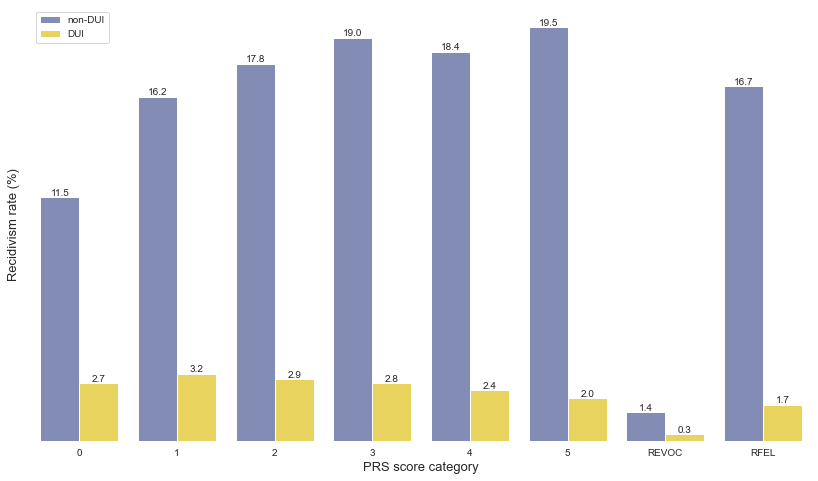

In [781]:
plot_category('NEXT_OFN_DUI', recidivism_pct, legend_loc = 'upper left')

### Recidivate to Felony Offense

A felony is defined as having an OGS >= 5 

In [264]:
ogs = offense_df.groupby(by=['ID_VARIABLE', 'DOS']).agg({'DOF': 'min', 'OGS': 'max'})

In [265]:
# get OGS score of by ID_VARIABLE and DOF for each individual
ogs = ogs.reset_index().groupby(by=['ID_VARIABLE', 'DOF'])['OGS'].max()

In [270]:
ogs = ogs.reset_index().rename(columns={'DOF': 'NEXT_DOF', 'OGS': 'NEXT_OGS'})

In [534]:
# combine with recidivism dataset
recidivism_df = pd.merge(recidivism_df, ogs, left_on=['ID_VARIABLE', 'NEXT_DOF'], right_on=['ID_VARIABLE', 'DOF'], how='left')

In [535]:
# check that files merged correctly
recidivism_df[(recidivism_df['RECIDIVISM_3Y']==1) & (recidivism_df['NEXT_OGS'].isna())][['ID_VARIABLE', 'NEW_DOS', 'NEW_DOF', 'PRS', 'AT_RISK_DT', 'NEXT_DOF', 'RECIDIVISM_3Y']]

,ID_VARIABLE,NEW_DOS,NEW_DOF,PRS,AT_RISK_DT,NEXT_DOF,RECIDIVISM_3Y
31770,1026099,2001-08-16,2000-02-11,2,2002-04-17,2002-11-27,1
164123,1134308,2003-09-02,2002-05-11,0,2003-12-25,2006-03-08,1
164648,1134758,2003-05-06,2002-01-02,3,2003-05-06,2004-10-23,1
184521,1150977,2003-12-23,2002-09-13,5,2004-06-23,2006-05-25,1
237893,1194974,2003-03-25,2002-10-19,0,2003-07-16,2003-08-10,1
257370,1210893,2002-05-03,2001-10-28,RFEL,2003-05-03,2005-10-26,1
386732,1316897,2004-03-18,2003-10-26,RFEL,2005-03-18,2005-09-08,1
449125,1367930,2001-06-26,2001-03-10,3,2001-07-04,2003-04-14,1
495242,1405684,2002-11-19,2000-06-11,3,2002-11-19,2004-01-12,1
792510,1648586,2002-06-03,2001-03-26,4,2003-05-18,2005-05-24,1


NOTE: there are several missing OGS scores, which seem related to violent offenses. 

In [539]:
offense_df[offense_df['OGS'].isna()]['LABEL'].unique()

array(['Homicide-Murder 2', 'Homicide-Murder 1',
       'Assault-By Life Prisoner', 'Arson-Homicide', 'Homicide-Inchoate'],
      dtype=object)

In [540]:
recidivism_df['RECIDIVATE_TO_FEL'] = np.where(recidivism_df['NEXT_OGS'] > 4, 1, 0)

In [541]:
# for NAs, also mark as recidivating to felony 
recidivism_df['RECIDIVATE_TO_FEL'].fillna(1, inplace=True)

In [701]:
labs = ['Non-Felony', 'Felony']

recidivism_counts, total_counts, recidivism_pct, cat_pct, labs = get_grouping(recidivism_df, 'RECIDIVATE_TO_FEL', labs)

In [697]:
recidivism_df[recidivism_df['RECIDIVISM_3Y']==1.0].groupby(by='RECIDIVATE_TO_FEL')['RECIDIVISM_3Y'].sum() / recidivism_df['RECIDIVISM_3Y'].sum()

RECIDIVATE_TO_FEL
0    0.665893
1    0.334107
Name: RECIDIVISM_3Y, dtype: float64

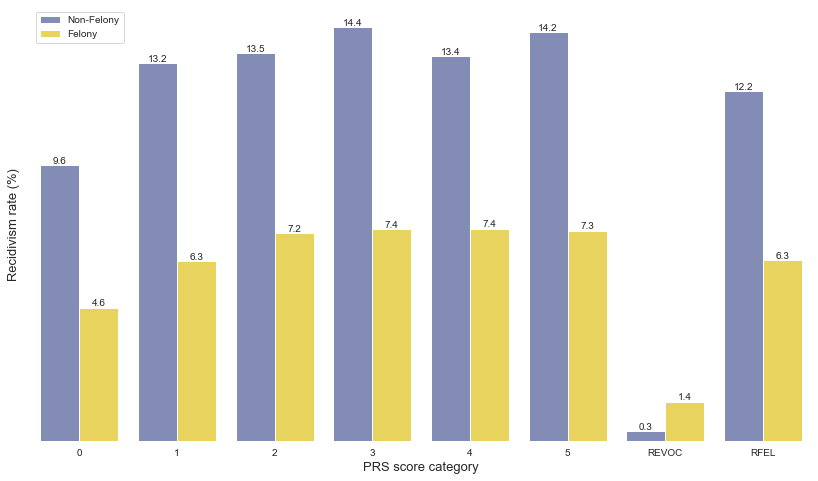

In [702]:
plot_category('RECIDIVATE_TO_FEL', recidivism_pct)

Recidivating to a felony by race

In [556]:
# category = ['RECIDIVATE_TO_FEL', 'OFF_RACE']
# recidivism_counts = recidivism_df[category + ['PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS', 'RECIDIVATE_TO_FEL', 'OFF_RACE']).agg({'RECIDIVISM_3Y':'sum'})
# total_counts = recidivism_df[category + ['PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS', 'OFF_RACE']).agg({'RECIDIVISM_3Y':'count'})
# recidivism_pct = recidivism_counts.div(total_counts).apply(lambda x: x * 100).reset_index()


In [615]:
# def get_grouping(df, category, labs = None):

#     recidivism_counts = df[[category, 'PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS', category]).agg({'RECIDIVISM_3Y':'sum'})
#     #total_counts = df[[category, 'PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS', category]).agg({'RECIDIVISM_3Y':'count'})
#     total_counts = df[['PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS']).agg({'RECIDIVISM_3Y':'count'})
#     recidivism_pct = recidivism_counts.div(total_counts).apply(lambda x: x * 100).reset_index()  
#     cat_pct = df.groupby(by=category)['RECIDIVISM_3Y'].sum()/len(recidivism_df[recidivism_df['RECIDIVISM_3Y']==1])
#     # for i in range(len(labs)):
#     #     labs[i] = labs[i] + ' {:.1f}%'.format(cat_pct.iloc[i] * 100)
#     if labs is not None:
#         recidivism_pct[category].replace(to_replace = list(range(len(labs))), value = labs, inplace=True)
#     return recidivism_counts, total_counts, recidivism_pct, cat_pct, labs

In [815]:
def get_sub_grouping(df, categories, group_var, labs = None):

    recidivism_counts = df[categories + ['PRS', 'RECIDIVISM_3Y']].groupby(by=['PRS'] + categories).agg({'RECIDIVISM_3Y':'sum'})

    total_counts = df[['PRS', 'RECIDIVISM_3Y', group_var]].groupby(by=['PRS', group_var]).agg({'RECIDIVISM_3Y':'count'})
    recidivism_pct = recidivism_counts.div(total_counts).apply(lambda x: x * 100).reset_index()  
    cat_pct = df.groupby(by=categories)['RECIDIVISM_3Y'].sum()/df.groupby(by=group_var)['RECIDIVISM_3Y'].sum()
    
    if labs is not None:
        recidivism_pct[categories].replace(to_replace = list(range(len(labs))), value = labs, inplace=True)
    
    return recidivism_counts, total_counts, recidivism_pct, cat_pct

In [816]:
recidivism_counts, total_counts, recidivism_pct, cat_pct = get_sub_grouping(categories = ['RECIDIVATE_TO_FEL', 'OFF_RACE'], 
group_var = 'OFF_RACE', df = recidivism_df[recidivism_df['OFF_RACE']!='Unknown'])

In [817]:
cat_pct

RECIDIVATE_TO_FEL  OFF_RACE
0                  Black       0.597906
                   Other       0.526953
                   White       0.695805
1                  Black       0.402094
                   Other       0.473047
                   White       0.304195
Name: RECIDIVISM_3Y, dtype: float64

In [813]:
recidivism_pct = recidivism_pct[recidivism_pct['RECIDIVATE_TO_FEL']==1]

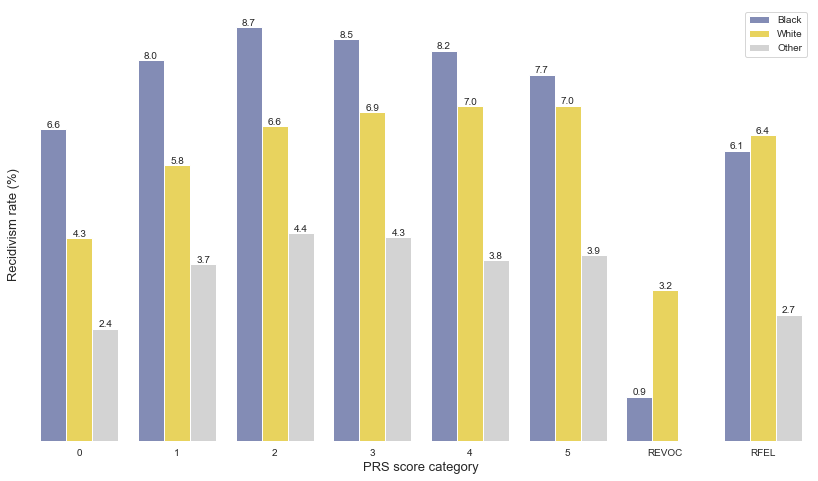

In [814]:
plot_category('OFF_RACE', recidivism_pct, legend_loc = 'upper right', palette = race_palette,
hue_order = ['Black', 'White', 'Other'])

### Recidivate to a non-drug related crime

In [782]:
offense_df[offense_df['LABEL'].str.lower().str.contains('drug')]['LABEL'].unique()

array(['Drug-Felony', 'Drug-Misd', 'Homicide-Drug Delivery',
       'Robbery-F1 (drug-related)'], dtype=object)

In [783]:
offense_df[offense_df['LABEL'].str.lower().str.contains('substance')]['LABEL'].unique()

array(['DUI-controlled substances: metabolite of Sched I/II/III (3rd/subsq off)'],
      dtype=object)

In [784]:
drug_offenses = ['drug-misd']

In [787]:
offense_df['NON_DRUG_OFN'] = offense_df['LABEL'].apply(lambda x: 1 if x.lower() not in drug_offenses else 0)

In [788]:
offense_df[offense_df['NON_DRUG_OFN']==0]

,JPR_ID,ID_VARIABLE,DOS,DOF,OFN_LABEL,LABEL,OGS,_DOS,_DOF,DUI,NON_DRUG_OFN
40,668825,1673626,2001-12-28,2001-08-05,Simple Possession,Drug-Misd,3.0,2001-12-28,2001-08-05,0,0
56,660950,1371759,2001-02-05,2000-10-10,Possession of Drug Paraphernalia,Drug-Misd,1.0,2001-02-05,2000-10-13,0,0
76,651469,1882432,2001-06-27,2000-08-22,Simple Possession,Drug-Misd,3.0,2001-06-27,2000-08-22,0,0
82,634264,1895340,2001-03-07,2000-05-02,Simple Possession,Drug-Misd,3.0,2001-03-07,2000-05-02,0,0
83,631362,1549552,2001-07-06,2001-05-24,Possession: Small Amount of Marijuana (<=30 g...,Drug-Misd,1.0,2001-07-06,2001-05-24,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2593602,6030650,1312618,2019-08-07,2019-06-25,Simple possession (2nd/subsq off),Drug-Misd,3.0,2019-08-07,2019-06-25,0,0
2593605,5948111,1200012,2019-04-22,2018-09-03,Possession-small amt. of marijuana (<=30 g/<=8...,Drug-Misd,1.0,2019-04-22,2018-09-03,0,0
2593618,5917947,1159755,2019-09-20,2018-07-03,Simple possession (2nd/subsq off),Drug-Misd,3.0,2019-09-20,2018-07-03,0,0
2593623,5967619,1849176,2019-02-01,2018-10-02,Possession-drug paraphernalia,Drug-Misd,1.0,2019-02-01,2018-10-02,0,0


There may be cases where a person is charged for both a drug offense and non drug-related offense on the same day. We will count it as a non-drug related offense if at least one offense is not a drug-related offense.

In [789]:
drug_observations = offense_df[['ID_VARIABLE', 'DOF', 'NON_DRUG_OFN']].sort_values(
    by=['ID_VARIABLE', 'DOF', 'NON_DRUG_OFN'], 
    ascending=[True, True, False]).groupby(by=['ID_VARIABLE', 'DOF']).first().reset_index()

In [790]:
drug_observations.head()

,ID_VARIABLE,DOF,NON_DRUG_OFN
0,1000001,2009-06-25,1
1,1000002,2015-09-01,1
2,1000003,2001-09-07,0
3,1000003,2009-03-04,1
4,1000004,2013-09-19,0


In [792]:
recidivism_df = pd.merge(recidivism_df, drug_observations, left_on=['ID_VARIABLE', 'NEXT_DOF'], right_on=['ID_VARIABLE', 'DOF'], how='left')

In [793]:
recidivism_df.rename(columns={'NON_DRUG_OFN': 'NEXT_OFN_NON_DRUG'}, inplace=True)

In [794]:
recidivism_df[(recidivism_df['NEXT_DOF'].notna()) & (recidivism_df['NEXT_OFN_NON_DRUG'].isna())]

,ID_VARIABLE,NEW_DOS,NEW_DOF,PRS,NEW_INC_SANCTION_EXISTS,ADJ_JPMIN,AT_RISK_DT,COUNTY,NEXT_DOF,TIME_TO_RECIDIVATE,...,OFF_SEX,YOS,SENTENCING_COHORT,NEXT_OGS,RECIDIVATE_TO_FEL,DOF_x,DOF_y,NEXT_OFN_DUI,DOF,NEXT_OFN_NON_DRUG


In [825]:
labs = ['Drug-Misdemeanor', 'Other offenses']

recidivism_counts, total_counts, recidivism_pct, cat_pct, labs = get_grouping(recidivism_df, 'NEXT_OFN_NON_DRUG', labs)

In [826]:
recidivism_counts.groupby(by='NEXT_OFN_NON_DRUG').sum()/recidivism_counts.sum()

,RECIDIVISM_3Y
NEXT_OFN_NON_DRUG,
0.0,0.140493
1.0,0.859507


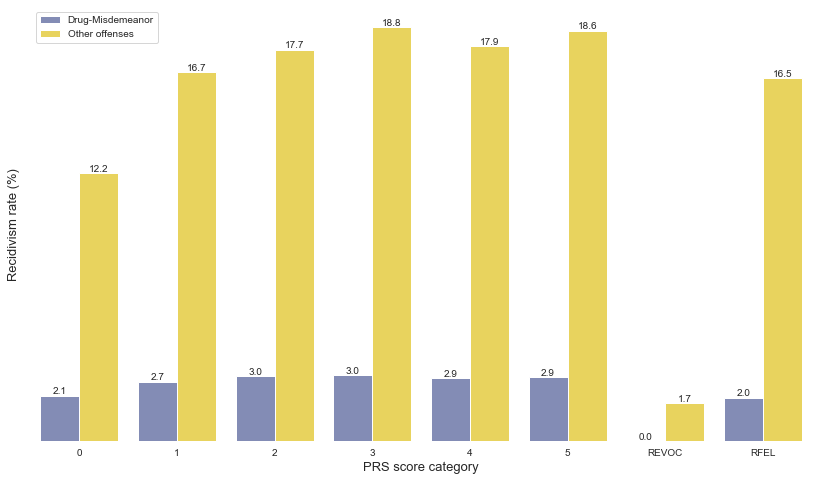

In [827]:
plot_category('NEXT_OFN_NON_DRUG', recidivism_pct)

Non-drug recidivism by race

In [819]:
recidivism_counts, total_counts, recidivism_pct, cat_pct = get_sub_grouping(categories = ['NEXT_OFN_NON_DRUG', 'OFF_RACE'], 
group_var = 'OFF_RACE', df = recidivism_df[recidivism_df['OFF_RACE']!='Unknown'])

In [821]:
recidivism_pct = recidivism_pct[recidivism_pct['NEXT_OFN_NON_DRUG'] == 1]

In [822]:
cat_pct

NEXT_OFN_NON_DRUG  OFF_RACE
0.0                Black       0.136869
                   Other       0.103410
                   White       0.142939
1.0                Black       0.863131
                   Other       0.896590
                   White       0.857061
Name: RECIDIVISM_3Y, dtype: float64

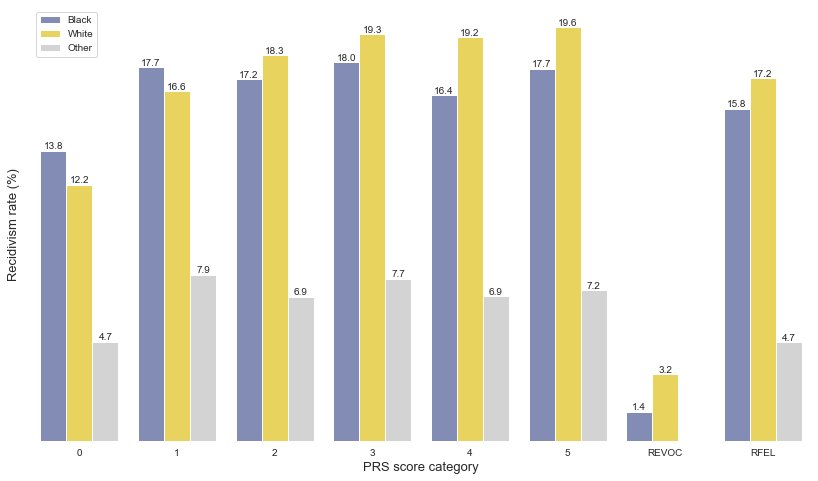

In [824]:
plot_category('OFF_RACE', recidivism_pct, palette = race_palette,
hue_order = ['Black', 'White', 'Other'])

In [594]:
recidivism_df.to_csv(filepath + 'recidivism_dataset_v2.csv', index=False)

In [595]:
print(len(recidivism_df)), print(len(recidivism_copy))

1119074
1119074


(None, None)